In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense
from tensorflow.keras.layers import Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional

SAMPLING_RATE = 8000
DROPOUT = 0.3

# 1
inputs = Input(shape=(SAMPLING_RATE, 1))

# 2
x = BatchNormalization()(inputs)
x = Conv1D(filters=8, kernel_size=13, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=DROPOUT)(x)

# 3
x = Conv1D(16, 11, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(DROPOUT)(x)

# 4
x = Conv1D(32, 9, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(DROPOUT)(x)
x = BatchNormalization()(x)

# 5
x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=False), merge_mode='sum')(x)

# 6
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization (Batch  (None, 8000, 1)           4         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424  

In [2]:
# pip install matplotlib
# pip install librosa # 오디오파일
# pip install tqdm # 반복문 실행상태 표시기

In [3]:
import librosa
import librosa.display

In [4]:
sound, rate = librosa.load('yes-sample.wav')

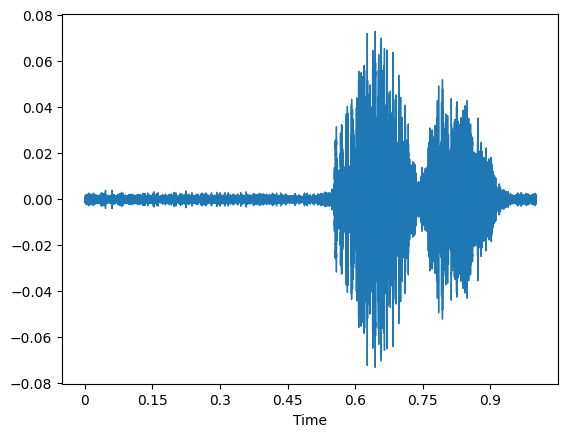

In [5]:
import matplotlib.pyplot as plt
librosa.display.waveshow(sound, sr=rate)
plt.show()

In [6]:
import IPython
IPython.display.Audio('yes-sample.wav')

In [7]:
import numpy as np
labels = np.array(['go', 'happy', 'seven', 'stop', 'yes'])
print(labels)

['go' 'happy' 'seven' 'stop' 'yes']


In [8]:
import os
dirs = [ f for f in os.listdir('./audio') if not os.path.isdir(f) ]
print(dirs)

['go', 'happy', 'seven', 'stop', 'yes']


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(dirs)
labels = encoder.classes_
print(labels)

['go' 'happy' 'seven' 'stop' 'yes']


In [10]:
from tqdm import tqdm
import numpy as np

def read_wave():
    all_wave = []
    all_label = []
    for label in tqdm(labels):
        path = './audio/' + label
        waves = [f for f in os.listdir(path)]
        for wav in waves:
            file = path + '/' + wav
            samples, rate = librosa.load(file, sr=16000)
            samples = librosa.resample(samples, orig_sr=rate, target_sr=SAMPLING_RATE)
            if(len(samples)==SAMPLING_RATE):
                all_wave.append(samples)
                all_label.append(label)

    all_label = encoder.transform(all_label)
    all_wave = np.array(all_wave).reshape(-1, SAMPLING_RATE, 1)

    return all_wave, all_label

In [11]:
import numpy as np

if os.path.exists('audio.npy'):
    with open('audio.npy', 'rb') as f:
        all_wave = np.load(f)
        all_label = np.load(f)
else:
    all_wave, all_label = read_wave()
    with open('audio.npy', 'wb') as f:
        np.save(f, all_wave)
        np.save(f, all_label)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_wave, all_label)
print(X_train.shape, y_train.shape)

(666, 8000, 1) (666,)


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [14]:
if os.path.exists('speech.h5'):
    model.load_weights('speech.h5')
    print('weight 파일을 로드했습니다.')
else:
    model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=1)
    model.save_weights('speech.h5')
    print('학습된 weight를 저장했습니다')

weight 파일을 로드했습니다.


In [15]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 163ms/step - loss: 0.3353 - accuracy: 0.9327


[0.3353419601917267, 0.9327354431152344]

In [16]:
sample_file = './audio/happy/d31d8dd7_nohash_0.wav'
y, sr = librosa.load(sample_file) #임의 파일
y_sample = librosa.resample(y, orig_sr=sr, target_sr=SAMPLING_RATE)
print(y_sample.shape) # 8000, 1

(8000,)


In [17]:
pred = model.predict(y_sample.reshape(-1, SAMPLING_RATE, 1))
# print(pred)
y_pred = np.argmax(pred[0])
print(y_pred)
print(labels[y_pred])

1/1 [==============================] - 1s 1s/step
1
happy


In [18]:
IPython.display.Audio(sample_file)

In [22]:
# 임의 파일 불러와 테스트 하기
import IPython
import os, random

rand_dir = random.choice(os.listdir("./audio"))
print(rand_dir)
rand_path = random.choice(os.listdir("./audio/" + rand_dir))
picked = os.path.join("./audio", rand_dir, rand_path)
picked_label = rand_dir
print(picked)
IPython.display.Audio(picked)

go
./audio\go\dc7ec25b_nohash_0.wav


In [23]:
# 사운드 읽어 텍스트 예측 후 반환하는 함수
def audio_to_text(audio):
    pred = model.predict(audio.reshape(1, SAMPLING_RATE, 1))
    index = np.argmax(pred[0])
    return labels[index]

In [24]:
# 오디오 loading, resampling, padding and reshape
# 텍스트 분류 예측
from tensorflow.keras.preprocessing.sequence import pad_sequences

y, sr = librosa.load(picked) # default sampling rate = 22050
sample = librosa.resample(y, orig_sr=sr, target_sr=SAMPLING_RATE)
sample = pad_sequences(np.array(sample).reshape(1, -1),
                       maxlen=SAMPLING_RATE, padding='post',
                       dtype=float)
sample = np.array(sample).reshape(-1, SAMPLING_RATE, 1)
print(audio_to_text(sample))

1/1 [==============================] - 0s 42ms/step
go
